In [ ]:
!nvidia-smi

Sat Apr 27 19:08:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   47C    P8             13W /  170W |     667MiB /  12288MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
IMAGE_SIZE = 640
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 1

RGB Red Green blue

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/Test",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 697 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Black Gill', 'Normal', 'Vibriosis', 'WSSV']

(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)


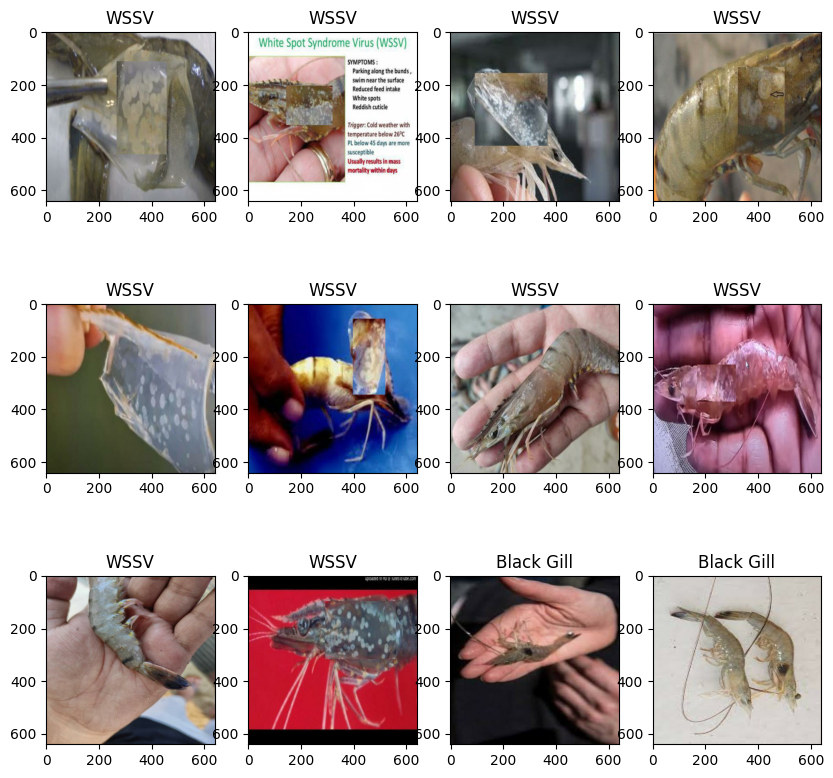

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    print(image_batch[i].shape)

In [ ]:
len(dataset)

22

In [ ]:
train_size = 0.8
len(dataset)*train_size

17.6

In [ ]:
train_ds = dataset.take(17)
len(train_ds)

17

In [ ]:
test_ds = dataset.skip(17)
len(test_ds)

5

In [ ]:
val_size=0.1
len(dataset)*val_size

2.2

NOTE: validation size is zero ;-; our dataset is small ill figure it out later

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)

  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return  train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

17

In [ ]:
len(val_ds)

2

In [ ]:
len(test_ds)

3

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

    ])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 640, 640, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 638, 638, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 319, 319, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 317, 317, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 158, 158, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 156, 156, 64)       

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=1,
)

17/17 [==============================] - 539s 31s/step - loss: 0.9511 - accuracy: 0.6853 - val_loss: 0.9554 - val_accuracy: 0.6719


In [ ]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 33s 8s/step - loss: 0.7064 - accuracy: 0.7292


In [ ]:
scores

[0.7063901424407959, 0.7291666865348816]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 1, 'steps': 17}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

1

In [ ]:
history.history['loss'][:5]

[0.9511319398880005]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

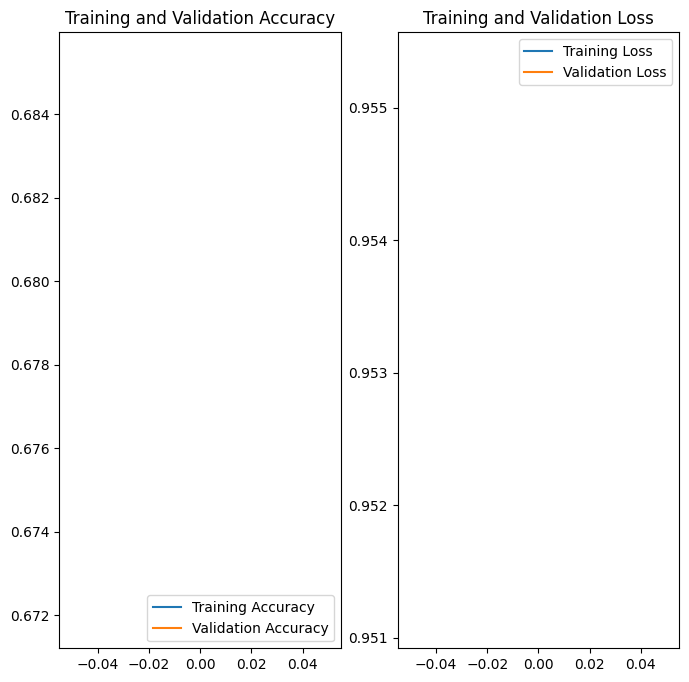

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: WSSV
1/1 [==============================] - 10s 10s/step
predicted label: WSSV


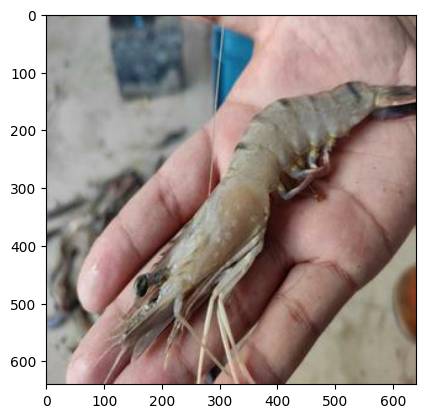

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 222ms/step


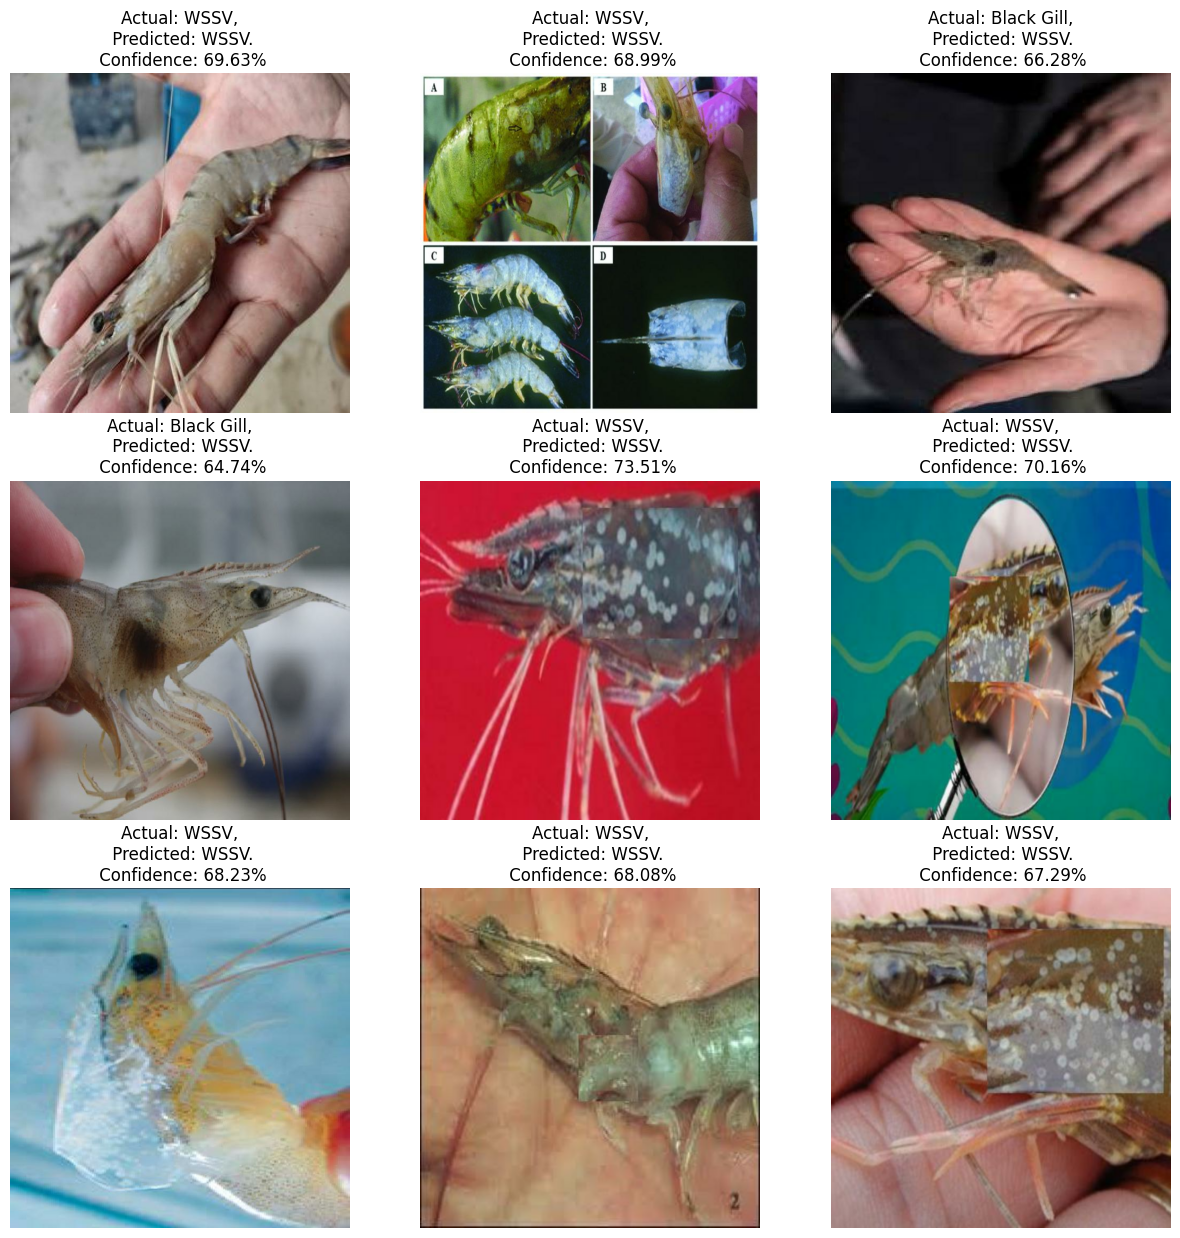

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
# Get list of model versions
model_versions = [int(i) for i in os.listdir("/content/drive/MyDrive/Colab Notebooks") if i.isdigit()]
# Increment the maximum version number
model_version = max(model_versions) + 1 if model_versions else 1
# Save the model
model.save(f"/content/drive/MyDrive/Colab Notebooks/model_{model_version}")

In [ ]:
model.save("Shrimple model 2")

1/1 [==============================] - 0s 330ms/step


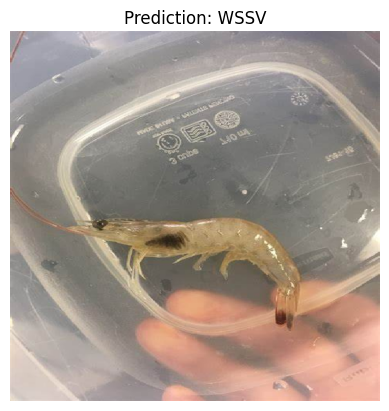

Displayed image: /content/drive/MyDrive/Colab Notebooks/Valid/Black gills/OH NO BLACK.jpeg
Predicted class: WSSV


In [ ]:
def predict_image(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0  # Normalize the image

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

    return img, predicted_class

sample_img_path = "/content/drive/MyDrive/Colab Notebooks/Valid/Black gills/OH NO BLACK.jpeg"
img, predicted_class = predict_image(model, sample_img_path, dataset.class_names)

print("Displayed image:", sample_img_path)
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 344ms/step


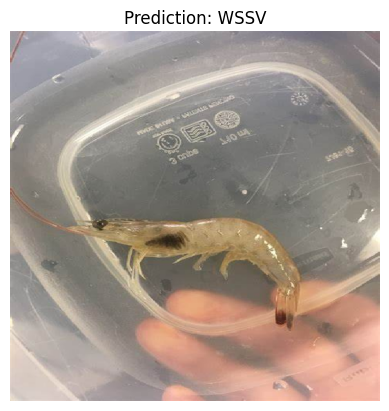

Displayed image: /content/drive/MyDrive/Colab Notebooks/Valid/Black gills/OH NO BLACK.jpeg
Predicted class: WSSV


In [ ]:
def load_saved_model(model_path):
    """
    Load a previously saved model from the specified path.

    Args:
    - model_path (str): The path to the saved model.

    Returns:
    - loaded_model: The loaded model.
    """
    loaded_model = tf.keras.models.load_model(model_path)
    return loaded_model

def predict_with_loaded_model(loaded_model, img_path, class_names):
    """
    Predict the class of an image using a loaded model.

    Args:
    - loaded_model: The loaded model.
    - img_path (str): The path to the image file.
    - class_names (list): List of class names.

    Returns:
    - img: The loaded image.
    - predicted_class (str): The predicted class.
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0  # Normalize the image

    prediction = loaded_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

    return img, predicted_class

# Example usage:
model_path = "/content/drive/MyDrive/Colab Notebooks/model_1"  # Path to the saved model
loaded_model = load_saved_model(model_path)

sample_img_path = "/content/drive/MyDrive/Colab Notebooks/Valid/Black gills/OH NO BLACK.jpeg"
img, predicted_class = predict_with_loaded_model(loaded_model, sample_img_path, dataset.class_names)

print("Displayed image:", sample_img_path)
print("Predicted class:", predicted_class)

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)